In [1]:
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import phate
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from math import *
import meld
import anndata as ad
from scipy import stats
from scipy.stats import pearsonr
import scipy.stats
import pylab as P
import seaborn as sns
import scvelo as scv

We will first read in the normalized data from Single Cell Portal (https://singlecell.broadinstitute.org/single_cell/study/SCP1318/human-small-intestinal-organoid-xpo1-inhibition)

In [2]:
organa = sc.read("hu_org_KPT_normalized_expression_counts.csv.gz")

In [5]:
organa = organa.T
organa

AnnData object with n_obs × n_vars = 2484 × 14679

Confirm gene name nomenclature

In [6]:
organa.var_names

Index(['A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAC', 'AADAT', 'AAED1', 'AAGAB',
       'AAK1', 'AAMDC',
       ...
       'ZNF23', 'ZNF252P-AS1', 'ZNF286B', 'ZNF483', 'ZNF572', 'ZNF610',
       'ZNF726', 'ZNF829', 'ZNF85', 'ZNF93'],
      dtype='object', length=14679)

In [7]:
organa.X

array([[1.2315671 , 0.29762486, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30286512, 0.        , 0.30286512, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Next, we will read in the metadata specifying the treatment label for each cell

In [8]:
metadata = pd.read_csv("Hu_intest_metadata.csv", index_col=0)
metadata

,array,treat,biosample_id,donor_id,cell_subset,sex,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label
NAME,,,,,,,,,,,,,,
GTCATCTAGATA,Sample_1,Ctrl,Ctrl-1,1,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
TTCAGAGACCCC,Sample_1,Ctrl,Ctrl-1,1,stem G2M,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
GTCCTTGAAGCG,Sample_1,Ctrl,Ctrl-1,1,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
ATTCGGATAGCG,Sample_1,Ctrl,Ctrl-4,3,enterocyte,male,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
CAGACTATAAAT,Sample_1,KPT,KPT-3,2,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGGTCGTGCTA,Sample_3,Ctrl,Ctrl-1,1,DUOX2+ WAE-like,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
GTAAGAATAGTC,Sample_3,Ctrl,Ctrl-1,1,stem G1S,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
TGCCTGTGGAAT,Sample_3,Ctrl,Ctrl-3,2,WAE-like,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well


In [10]:
list(metadata['treat'])

['Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctr

In [11]:
treatment = list(metadata['treat'])
organa.obs['Treatment'] = treatment

In [13]:
organa.obs['Treatment'] = organa.obs['Treatment'].astype('category')
organa.obs['Treatment']

GTCATCTAGATA    Ctrl
TTCAGAGACCCC    Ctrl
GTCCTTGAAGCG    Ctrl
ATTCGGATAGCG    Ctrl
CAGACTATAAAT     KPT
                ... 
GAGGTCGTGCTA    Ctrl
GTAAGAATAGTC    Ctrl
TGCCTGTGGAAT    Ctrl
ACAGAGTATCGT    Ctrl
TTTGAGAGTCCT     KPT
Name: Treatment, Length: 2484, dtype: category
Categories (2, object): ['Ctrl', 'KPT']

Next, we pull out the cell type annotations from the original study to help us assess Cellograph's performance

In [12]:
cell_type = list(metadata['cell_subset'])
organa.obs['cell_type'] = cell_type
organa.obs['cell_type'] = organa.obs['cell_type'].astype('category')
organa.obs['cell_type']

GTCATCTAGATA         enterocyte
TTCAGAGACCCC           stem G2M
GTCCTTGAAGCG         enterocyte
ATTCGGATAGCG         enterocyte
CAGACTATAAAT         enterocyte
                     ...       
GAGGTCGTGCTA    DUOX2+ WAE-like
GTAAGAATAGTC           stem G1S
TGCCTGTGGAAT           WAE-like
ACAGAGTATCGT         progenitor
TTTGAGAGTCCT         progenitor
Name: cell_type, Length: 2484, dtype: category
Categories (9, object): ['DUOX2+ WAE-like', 'WAE-like', 'enterocyte', 'enteroendocrine', ..., 'progenitor', 'quiescent progenitor', 'stem G1S', 'stem G2M']

In [15]:
organa.obs['Treatment'] = organa.obs['Treatment'].astype('category')
organa.obs['Treatment']

AAACCTGAGAGGTTAT-1_1            normal
AAACCTGAGCTCCTCT-1_1            normal
AAACCTGAGTCGATAA-1_1            normal
AAACCTGCACATGACT-1_1            normal
AAACCTGCACGCGAAA-1_1            normal
                             ...      
TTTGTCATCAATACCG-2_2    aortic disease
TTTGTCATCTCTTATG-2_2    aortic disease
TTTGTCATCTGCTTGC-2_2    aortic disease
TTTGTCATCTTGCAAG-2_2    aortic disease
TTTGTCATCTTGCATT-2_2    aortic disease
Name: Diet, Length: 24001, dtype: category
Categories (2, object): ['aortic disease', 'normal']

Now, we will perform a PCA reduction to 100 PCs as input for our kNN graph construction

In [14]:
sc.tl.pca(organa, n_comps=100, svd_solver='arpack')

Habitually save the analysis into an .h5ad file for convenience

In [15]:
results_file = "organa_preprocessed_init.h5ad"
organa.write(results_file)

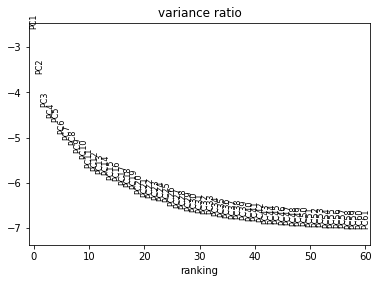

In [21]:
sc.pl.pca_variance_ratio(organa, n_pcs=60, log=True)

Creata a kNN graph from 60 PCs with $k=15$

In [22]:
sc.pp.neighbors(organa, n_neighbors=15, n_pcs=60)

Visualize inspect the data with something like UMAP

In [23]:
sc.tl.umap(organa)

In [36]:
organa.obs

,Diet,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
CGACTTCCACTCAGGC-1_1,normal,smooth muscle cell,2206,6265.0,466.0,7.438148
CACTCCAAGCTAGCCC-1_2,aortic disease,macrophage,2358,6937.0,318.0,4.584114
CGAGCACTCGCACTCT-2_1,normal,macrophage,1405,4239.0,235.0,5.543760
ATCATCTAGACACTAA-2_1,normal,fibroblast,1032,2149.0,78.0,3.629595
GACCTGGGTCGAGATG-1_2,aortic disease,fibroblast,1741,4323.0,239.0,5.528568
...,...,...,...,...,...,...
TGGCGCAGTCTAGGTT-2_2,aortic disease,smooth muscle cell,2117,6406.0,381.0,5.947549
ATCGAGTAGTGCTGCC-2_1,normal,fibroblast,1561,4242.0,144.0,3.394625
ACTGCTCCAAGGCTCC-2_1,normal,endothelial cell,1497,3798.0,214.0,5.634544
GGCGACTGTCGCGGTT-2_2,aortic disease,smooth muscle cell,2039,5503.0,312.0,5.669635


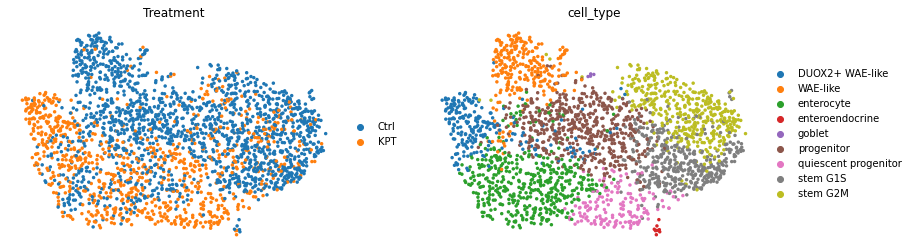

In [24]:
sc.pl.umap(organa, color=['Treatment', 'cell_type'], frameon = False)

Extract corresponding adjacency matrix and basic summary information of the graph's nodes and edges

In [25]:
A = organa.obsp['connectivities']

Retrive labels of each cell's ground truth condition (Control or KPT330)

In [27]:
labels = organa.obs['Treatment']

In [28]:
labels = np.array(labels.astype('str'))
labels = list(labels)
labels

['Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'Ctrl',
 'KPT',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'KPT',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctrl',
 'Ctr

Now, we begin preparing the data for training. We extract 20 cells for each treatment label for training, following by 400 cells for validation and another 400 for testing

In [29]:
def limit_data(labels,limit=20,val_num=400,test_num=400):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            train_idx.append(i)
            label_counter[label]+=1
        
        if all(count == limit for count in label_counter.values()):
            break
    
    
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [30]:
len(test_idx)

400

In [31]:
N = len(organa.obs.index) # number of nodes/cells
N

2484

In [32]:
X = organa.X

In [33]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

Look at the distribution of labels for cells in each set of cells for our GCN

In [34]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Ctrl': 20, 'KPT': 20})


In [35]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Ctrl': 249, 'KPT': 151})


In [36]:
print("Test Data Distribution: \n{}".format(Counter([labels[i] for i in test_idx])))

Test Data Distribution: 
Counter({'Ctrl': 266, 'KPT': 134})


One-hot encoding of the labels (2-D array of vectors where [1,0] means the cell is from control and [0,1] means the cell is from the KPT330 treatment)

In [37]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [38]:
F = len(organa.var) # number of features (i.e., genes)
F

14679

In [39]:
num_classes = 2 # number of classes
n_out = 2 # number of classes

## GCN Model
Set up the model with one input layer and  two convolutional layers (one to generate a learned embedding, and another to generate the probabilities of belonging to one class versus another)

In [40]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 30        # Patience for early stopping

# Preprocessing operations
A = organa.obsp['connectivities']
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_Treatment',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14679)]      0           []                               
                                                                                                  
 dropout (Dropout)              (None, 14679)        0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2484)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 16)           234864      ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

Train GCN model

In [41]:
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.0273 - acc: 0.5000 - val_loss: 1.6923 - val_acc: 0.3775
Epoch 2/200
1/1 [==============================] - 0s 350ms/step - loss: 0.1989 - acc: 0.4500 - val_loss: 7.5057 - val_acc: 0.6225
Epoch 3/200
1/1 [==============================] - 0s 317ms/step - loss: 1.0937 - acc: 0.5000 - val_loss: 6.1086 - val_acc: 0.6225
Epoch 4/200
1/1 [==============================] - 0s 339ms/step - loss: 0.8916 - acc: 0.5000 - val_loss: 1.2597 - val_acc: 0.6225
Epoch 5/200
1/1 [==============================] - 0s 323ms/step - loss: 0.2056 - acc: 0.5250 - val_loss: 7.6397 - val_acc: 0.3775
Epoch 6/200
1/1 [==============================] - 0s 343ms/step - loss: 0.7127 - acc: 0.5000 - val_loss: 10.3441 - val_acc: 0.3775
Epoch 7/200
1/1 [==============================] - 0s 354ms/step - loss: 0.9432 - acc: 0.5000 - val_loss: 9.5496 - val_acc: 0.3775
Epoch 8/200
1/1 [==============================] - 0s 320ms/step - loss: 0.8537 - acc

Output class probabiltiies from the GCN

In [42]:
y_pred_all = model.predict([X, A], batch_size=N)

Save these probabilities for convenience in revisiting

In [43]:
pd.DataFrame(y_pred_all).to_csv("softmax_gcn.csv")

In [44]:
y_pred = y_pred_all[test_mask]

In [45]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

In [46]:
# See how well it performed on the testing set of data
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

        Ctrl       0.94      0.89      0.92       266
         KPT       0.81      0.90      0.85       134

    accuracy                           0.89       400
   macro avg       0.87      0.89      0.88       400
weighted avg       0.90      0.89      0.89       400



Get PHATE embedding the hidden layer representation from the first GCN layer

In [47]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

phate_operator = phate.PHATE()
x_phate = phate_operator.fit_transform(activations[3])

Calculating PHATE...
  Running PHATE on 2484 observations and 16 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.26 seconds.
  Calculated landmark operator in 4.03 seconds.
  Calculating optimal t...
    Automatically selected t = 43
  Calculated optimal t in 0.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.62 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.46 seconds.
Calculated PHATE in 9.16 seconds.


In [70]:
organa.write(results_file)

Save the PHATE coordinates

In [48]:
pd.DataFrame(x_phate).to_csv("phate_gcn.csv")

In [77]:
x_phate

array([[-0.02471061,  0.00214018],
       [-0.0195602 ,  0.00597442],
       [-0.01162303, -0.01303436],
       ...,
       [-0.02442895,  0.00201859],
       [-0.01918379,  0.00932031],
       [ 0.02742556, -0.00353495]])

Save the 16-dimensional latent space learned by the GCN in the first layer 

In [49]:
pd.DataFrame(activations[3]).to_csv("activations_gcn.csv")

In [50]:
labels2 = list(classes)
labels2

['Ctrl', 'KPT']

Visualize the PHATE embedding of the learned latent space

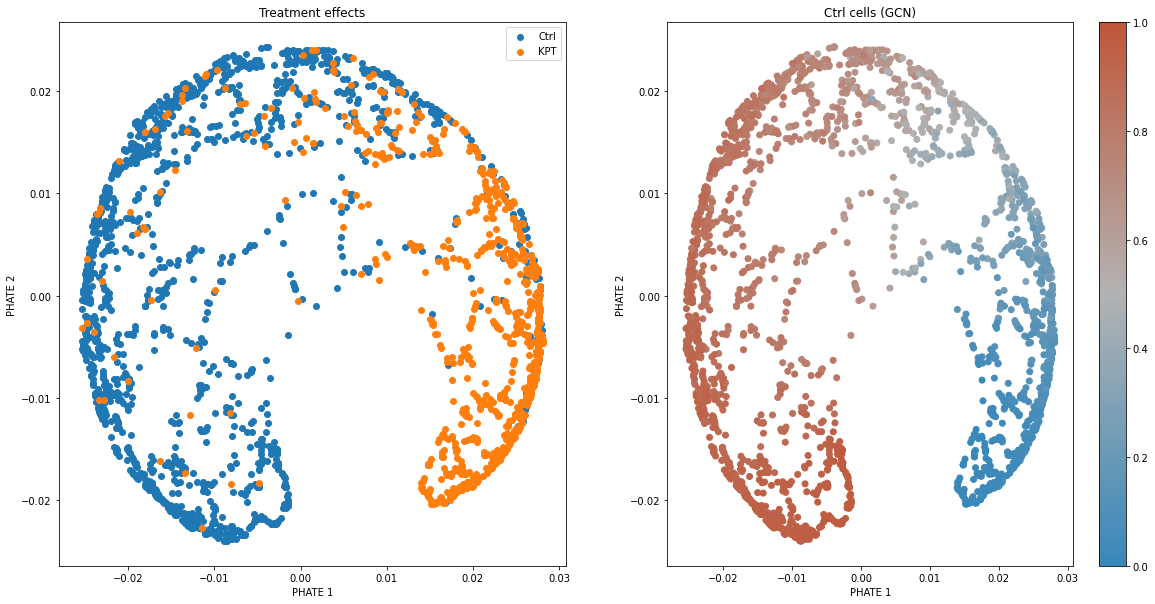

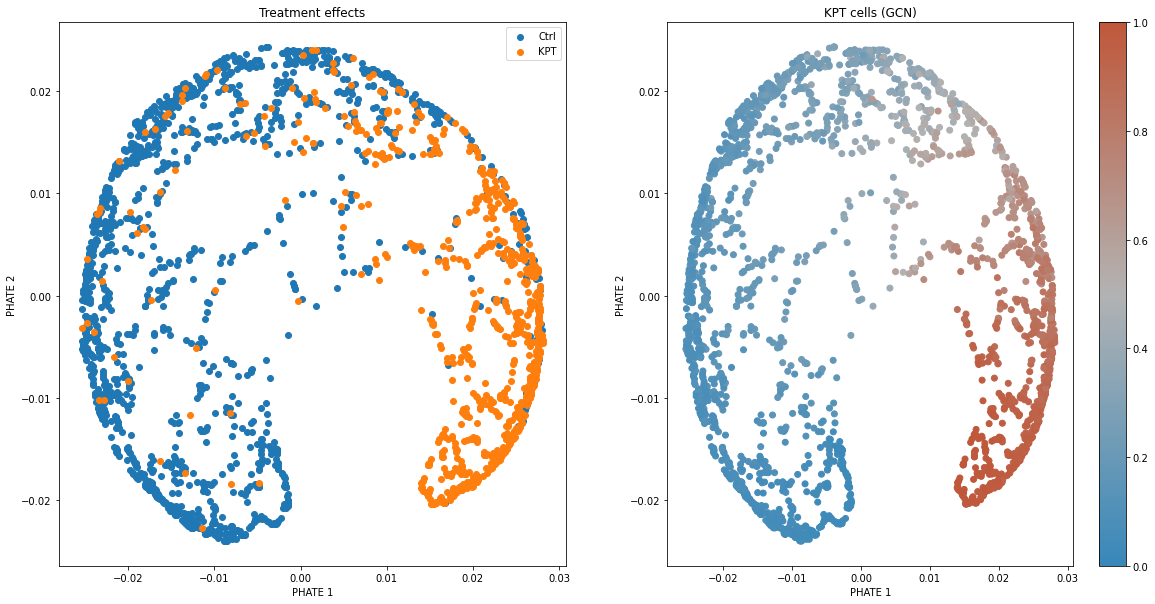

In [51]:
# Now color cells according to probabilities of belonging in each of the treatment groups
def plot_PHATE_heat(labels_encoded,x_phate, cell_type):
    color_map = np.argmax(labels_encoded, axis=1)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        ax1.scatter(x_phate[indices,0], x_phate[indices, 1], label=labels2[cl])
        z2_plot = ax2.scatter(x_phate[indices,0], x_phate[indices, 1], c=y_pred_all[indices,labels2.index(cell_type)], 
                    cmap=meld.utils.get_meld_cmap(), vmin = 0, vmax = 1)
    #plt.legend()
    #fig.colorbar(im = im, ax = ax2)
    ax1.legend()
    plt.colorbar(z2_plot, ax = ax2)
    ax1.set_xlabel('PHATE 1')
    ax1.set_ylabel('PHATE 2')
    ax1.set_title('Treatment effects')
    ax2.set_xlabel('PHATE 1')
    ax2.set_ylabel('PHATE 2')
    #ax2_set_colorbar()
    ax2.set_title(cell_type + ' cells (GCN)')
    #plt.show()
    #fig.savefig("GCN_phate_prob_" + cell_type + ".png", dpi = fig.dpi)

for label in labels2:
    plot_PHATE_heat(labels_encoded,x_phate, label)


Save the scanpy object

In [162]:
organa.obsm['X_tsne'] = x_phate
organa.write(results_file)

In [163]:
organa

AnnData object with n_obs × n_vars = 2484 × 14679
    obs: 'Treatment', 'cell_type', 'kMeans', 'Clusters', 'kMeans_orig'
    uns: 'pca', 'neighbors', 'umap', 'Treatment_colors', 'cell_type_colors', 'kMeans_colors', 'rank_genes_groups', 'dendrogram_kMeans', 'Clusters_colors', 'dendrogram_Clusters'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [167]:
GCN

,Ctrl,KPT,Method,Treatment,Prediction,Clusters,Clusters_orig
0,0.861448,0.138552,GCN,Ctrl,Ctrl,Naive,0
1,0.821678,0.178322,GCN,Ctrl,Ctrl,Naive,1
2,0.861835,0.138165,GCN,Ctrl,Ctrl,Naive,1
3,0.805896,0.194104,GCN,Ctrl,Ctrl,Naive,0
4,0.088442,0.911558,GCN,KPT,KPT,Responsive,0
...,...,...,...,...,...,...,...
2479,0.237696,0.762304,GCN,Ctrl,KPT,Responsive,2
2480,0.704624,0.295376,GCN,Ctrl,Ctrl,Intermediate,1
2481,0.901365,0.098635,GCN,Ctrl,Ctrl,Naive,2
2482,0.884578,0.115422,GCN,Ctrl,Ctrl,Intermediate,2


Multi-panel plot with select markers, clusters, and treatment labels

In [161]:
results_file = '/mnt/c/Users/Jamshaid/Documents/Medium/Cellograph/Organoid/Human/organa_preprocessed_init.h5ad'

In [145]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [52]:
# Estimate density of each sample over the graph
sample_densities = meld.MELD().fit_transform(organa.X, np.array(labels))

# Normalize densities to calculate sample likelihoods
sample_likelihoods = meld.utils.normalize_densities(sample_densities)

Building graph on 2484 samples and 14679 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 2.59 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.47 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 3.17 seconds.


In [53]:
sample_likelihoods

,Ctrl,KPT
0,0.385049,0.614951
1,0.609528,0.390472
2,0.456247,0.543753
3,0.427074,0.572926
4,0.387571,0.612429
...,...,...
2479,0.365822,0.634178
2480,0.570431,0.429569
2481,0.608113,0.391887
2482,0.505858,0.494142


In [169]:
np.argmax(labels_encoded, axis=1)

array([0, 3, 5, ..., 5, 2, 5])

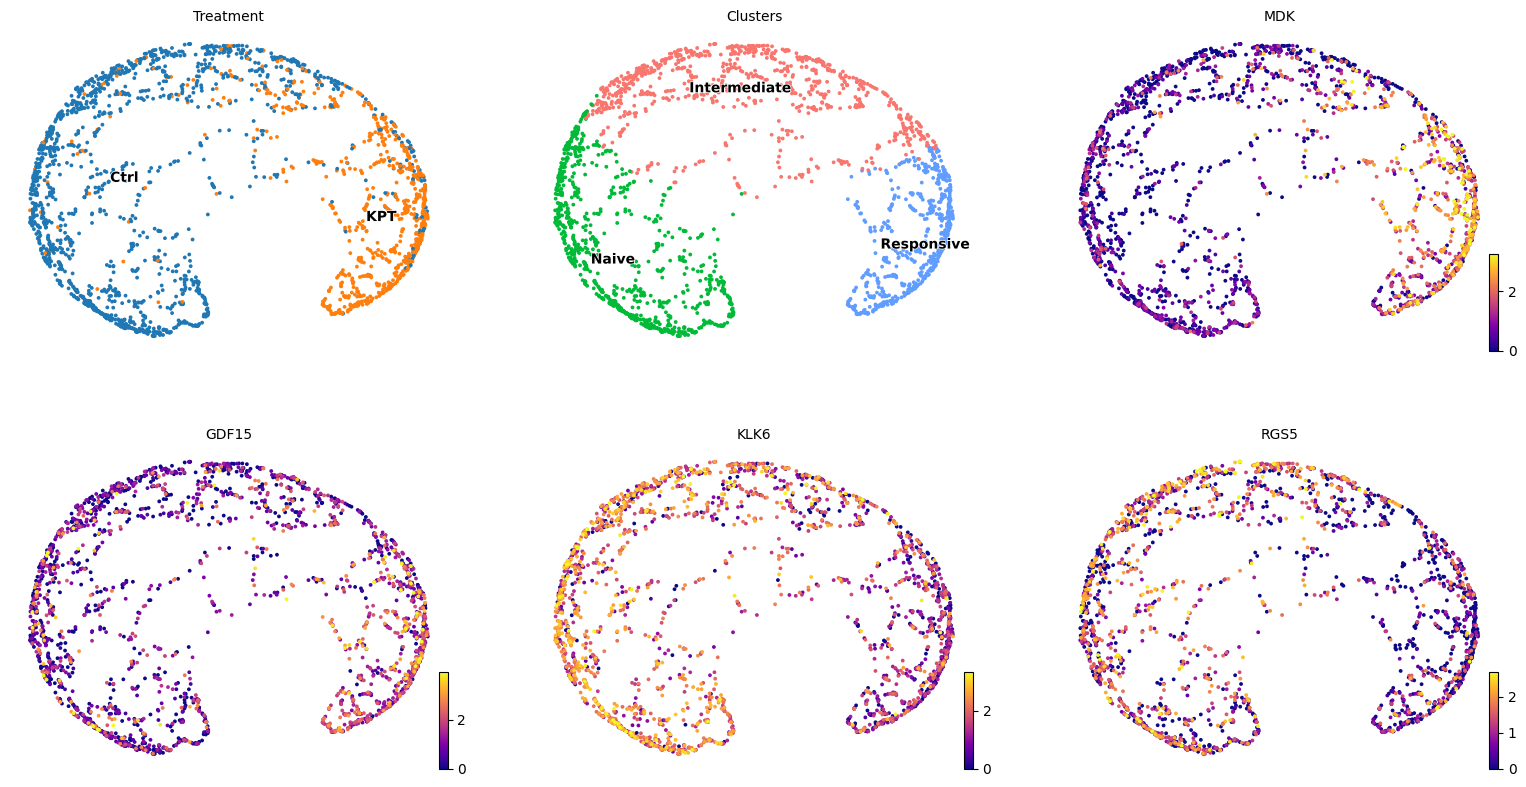

In [169]:
scv.pl.scatter(organa, basis='tsne', ncols=3, color = ['Treatment', 'Clusters', 'MDK', 'GDF15', 'KLK6', 'RGS5'], cmap = 'plasma', perc = [1,99], s = 30, legend_loc='on data')

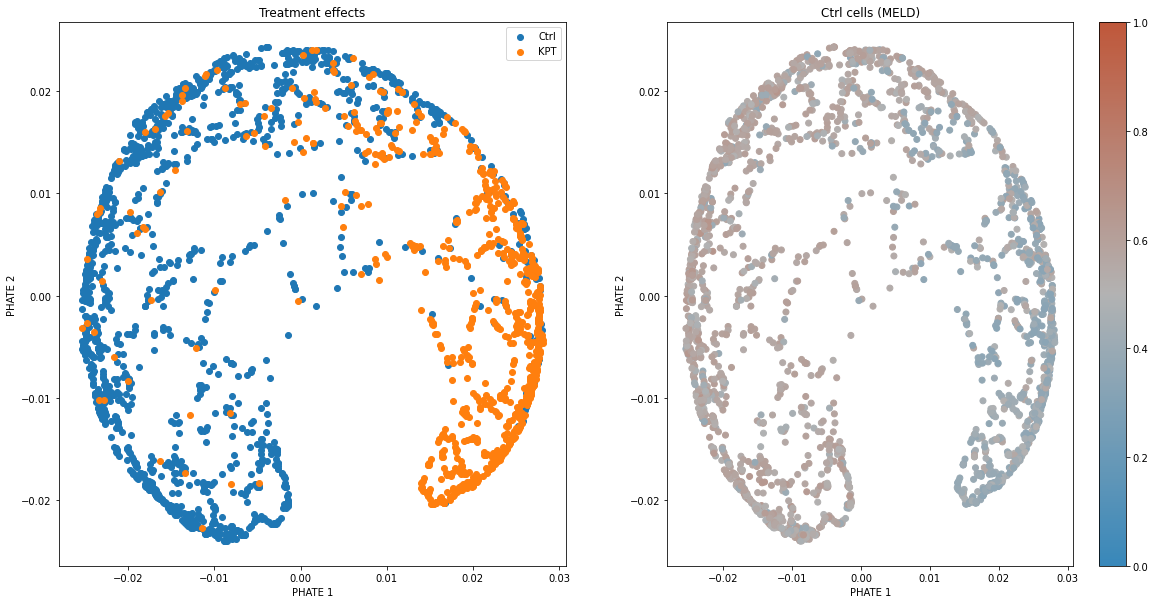

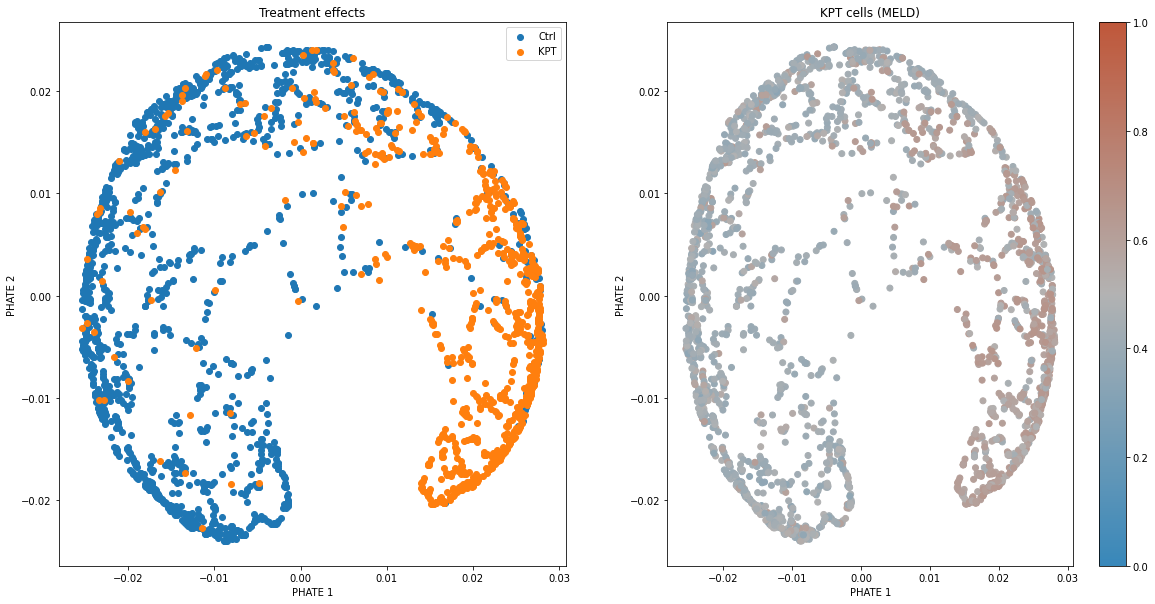

In [54]:
# Now color cells according to probabilities of belonging in 0 nM treatment group
def plot_PHATE_heat(labels_encoded,x_phate, cell_type):
    color_map = np.argmax(labels_encoded, axis=1)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        ax1.scatter(x_phate[indices,0], x_phate[indices, 1], label=labels2[cl])
        z2_plot = ax2.scatter(x_phate[indices,0], x_phate[indices, 1], c=sample_likelihoods[cell_type][indices], 
                    cmap=meld.utils.get_meld_cmap(), vmin = 0, vmax = 1)
    
    ax1.legend()
    plt.colorbar(z2_plot, ax = ax2)
    ax1.set_xlabel('PHATE 1')
    ax1.set_ylabel('PHATE 2')
    ax1.set_title('Treatment effects')
    ax2.set_xlabel('PHATE 1')
    ax2.set_ylabel('PHATE 2')
    #ax2_set_colorbar()
    ax2.set_title(cell_type + ' cells (MELD)')
    #plt.show()
    fig.savefig("MELD_phate_prob_" + cell_type + ".png", dpi = fig.dpi)

for label in labels2:
    plot_PHATE_heat(labels_encoded,x_phate, label)


# Visualize learned weight matrix

We can extract the weight matrix from the first layer of the GCN where rows correspond to genes weighted by how important they are in distinguishes between the treatment labels. We can then make a heatmap of the top weighted genes.

In [55]:
weights = [layer.get_weights() for layer in model.layers]
weights

[[],
 [],
 [],
 [array([[ 2.3028047e-06,  1.9376117e-07, -7.8774965e-04, ...,
          -2.3087296e-05, -1.0739513e-05,  1.6110270e-06],
         [ 3.2379964e-07,  1.0119257e-07, -1.7465533e-06, ...,
           2.9538462e-06,  1.9358929e-06,  5.0516348e-07],
         [-1.5769842e-08, -2.3966754e-07,  2.4046174e-06, ...,
           4.2361089e-06,  2.3343500e-06,  2.2613762e-08],
         ...,
         [-1.4950703e-07,  2.3401765e-07,  5.6627698e-08, ...,
           5.8987564e-07, -4.6995854e-07,  1.7974608e-07],
         [-2.4942523e-08, -2.8559671e-07,  4.4636377e-07, ...,
          -3.0900966e-07, -4.1423746e-07,  1.9113733e-07],
         [-6.5853314e-08,  2.2169587e-07, -1.5735117e-07, ...,
          -9.9429326e-07, -1.5379771e-07,  1.2852078e-07]], dtype=float32)],
 [],
 [array([[ 0.34268662,  0.37268314],
         [-0.393379  , -0.22223681],
         [ 0.41606143, -0.20756862],
         [-0.22316255,  0.45685616],
         [ 0.0296084 ,  0.00992385],
         [ 0.50739366, -0.43530

In [56]:
np.shape(weights[3][0])

(14679, 16)

In [57]:
df_weights = pd.DataFrame(weights[3][0])
df_weights.index = organa.var_names
df_weights

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
A1CF,2.302805e-06,1.937612e-07,-7.877497e-04,-3.556234e-06,-7.146614e-06,-2.534295e-03,-0.001666,0.015367,-0.006659,1.399694e-03,-4.792936e-04,8.760213e-06,-8.820542e-04,-2.308730e-05,-1.073951e-05,1.611027e-06
A4GALT,3.237996e-07,1.011926e-07,-1.746553e-06,-1.059509e-07,1.132542e-06,3.522925e-07,0.000337,-0.013347,0.011085,-6.831052e-06,3.963519e-06,1.624459e-06,-3.520202e-07,2.953846e-06,1.935893e-06,5.051635e-07
AAAS,-1.576984e-08,-2.396675e-07,2.404617e-06,1.826659e-06,3.354221e-06,3.020301e-06,0.000430,0.003406,-0.005426,7.981973e-06,-2.600596e-06,-2.613019e-06,5.208369e-06,4.236109e-06,2.334350e-06,2.261376e-08
AACS,-9.846699e-07,2.277977e-06,-2.610252e-03,-6.430027e-06,8.917946e-06,-3.870859e-03,0.001182,-0.007758,0.006053,-9.863138e-03,-2.045910e-03,-2.220614e-06,-2.279270e-04,1.981442e-05,1.759134e-05,-2.029733e-06
AADAC,5.361951e-07,1.297851e-07,1.489398e-05,-1.371239e-06,2.262154e-06,2.131043e-05,-0.002792,0.002438,-0.003587,8.621629e-04,-9.707849e-07,9.532519e-07,1.288262e-06,-1.360531e-05,-5.177535e-06,-2.828197e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF610,-1.587833e-07,4.253364e-07,-6.249206e-07,6.555578e-08,1.232376e-07,-1.777516e-08,0.000059,0.000635,-0.000045,6.074874e-07,-9.061569e-08,-5.408106e-07,1.648379e-07,-2.958217e-09,-1.635030e-07,3.469809e-07
ZNF726,2.054242e-07,-1.923991e-07,6.165953e-08,-3.925302e-07,-3.917013e-07,1.156290e-07,0.000120,0.000873,-0.000368,6.263442e-07,2.185060e-07,-6.063908e-07,-7.316902e-07,-9.881057e-08,-2.351124e-07,-1.391236e-07
ZNF829,-1.495070e-07,2.340176e-07,5.662770e-08,-3.055859e-08,-2.192537e-07,-2.512892e-07,0.000034,0.000248,-0.000158,2.132127e-08,4.135297e-07,3.257330e-07,2.934140e-07,5.898756e-07,-4.699585e-07,1.797461e-07
ZNF85,-2.494252e-08,-2.855967e-07,4.463638e-07,-2.239192e-07,1.595105e-07,-4.000021e-07,-0.000019,-0.001559,-0.000346,-1.306171e-06,-9.008401e-07,8.434566e-07,-7.910978e-08,-3.090097e-07,-4.142375e-07,1.911373e-07


In [58]:
df_weights.to_csv("weights_gcn.csv")

In [59]:
maxfeatures = []
for gene in list(organa.var_names):
    maxfeatures.append(max(df_weights.loc[gene]))

In [60]:
highgenes = pd.Series(maxfeatures, index=list(organa.var_names))

Extract top weighted genes from learned weight matrix

In [62]:
import matplotlib
matplotlib.use('Agg')

In [64]:
top25 = highgenes.sort_values(ascending=False).iloc[0:25]

Visualize heatmap of top 25 genes between the treatment conditions

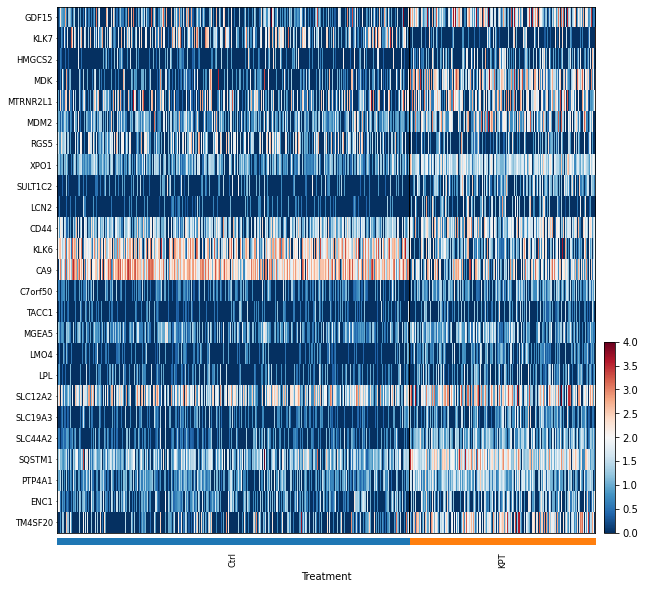

In [65]:
sc.pl.heatmap(organa, list(top25.index), groupby='Treatment', cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize = (10,10), vmin = 0, vmax = 4)
plt.savefig("top25gcnweights.png")

# Clustering

We can cluster the learned 16-dimension embedding space from the GCN using your favorite clustering method. Here, we use k-means clustering with $k=3$

In [101]:
from sklearn.cluster import KMeans

In [102]:
# Cluster the 16-dimensional latent space learned by the GNN
kmeans = KMeans(n_clusters=3, random_state=0).fit(activations[3])

In [114]:
# Cluster the PCA reduction of the single cell genomics data
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(organa.obsm['X_pca'][:,0:60])

In [113]:
organa.obsm['X_pca'][:,0:60].shape

(2484, 60)

In [115]:
kmeans_encoded, classes_k = encode_label(kmeans.labels_)
kmeans_encoded2, classes_k2 = encode_label(kmeans2.labels_)

In [104]:
klabels = [0, 1, 2]

In [109]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Choose visually distinctive colors for the clusters

In [105]:
color_list = ["#F8766D", "#00BA38", "#619CFF"]

Visualize the clusters on the PHATE embedding

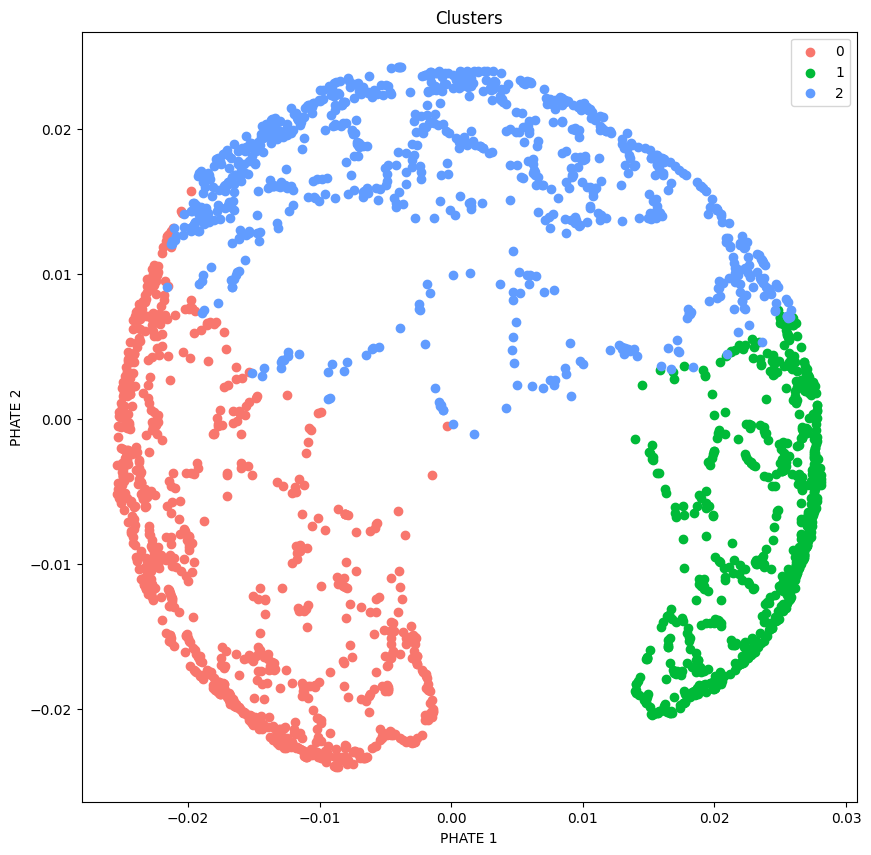

In [110]:
def plot_PHATE(labels_encoded,x_phate):
    color_list = ["#F8766D", "#00BA38", "#619CFF"]
    color_map = np.argmax(labels_encoded, axis=1)
    fig = plt.figure(figsize=(10,10))
    for cl in range(3):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_phate[indices,0], x_phate[indices, 1], label=klabels[cl], c = color_list[cl])
    plt.legend()
    plt.xlabel('PHATE 1')
    plt.ylabel('PHATE 2')
    plt.title("Clusters")
    plt.show()
    fig.savefig("GCN_phate_clusters.png", dpi = fig.dpi)
plot_PHATE(kmeans_encoded,x_phate)

Visualize k-means clusters from PCA reduction of original data for comparison

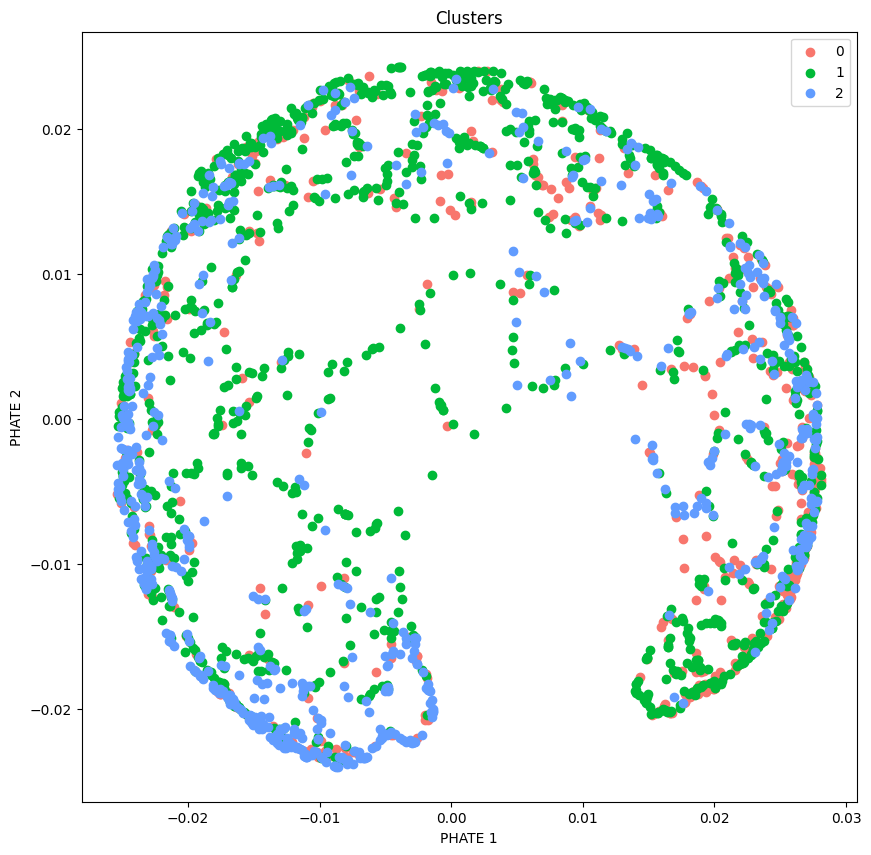

In [116]:
def plot_PHATE(labels_encoded,x_phate):
    color_list = ["#F8766D", "#00BA38", "#619CFF"]
    color_map = np.argmax(labels_encoded, axis=1)
    fig = plt.figure(figsize=(10,10))
    for cl in range(3):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_phate[indices,0], x_phate[indices, 1], label=klabels[cl], c = color_list[cl])
    plt.legend()
    plt.xlabel('PHATE 1')
    plt.ylabel('PHATE 2')
    plt.title("Clusters")
    plt.show()
    fig.savefig("GCN_phate_clusters_original.png", dpi = fig.dpi)
plot_PHATE(kmeans_encoded2,x_phate)

In [117]:
clusters = (pd.Series(kmeans.labels_).astype('str')).astype('category')
clusters

0       0
1       0
2       0
3       0
4       1
       ..
2479    1
2480    2
2481    0
2482    2
2483    1
Length: 2484, dtype: category
Categories (3, object): ['0', '1', '2']

In [145]:
clusters_orig = (pd.Series(kmeans2.labels_).astype('str')).astype('category')
clusters_orig

0       0
1       1
2       1
3       0
4       0
       ..
2479    2
2480    1
2481    2
2482    2
2483    2
Length: 2484, dtype: category
Categories (3, object): ['0', '1', '2']

In [119]:
organa.obs['kMeans'] = list(clusters)
organa.obs['kMeans'] = organa.obs['kMeans'].astype('category')

In [146]:
organa.obs['kMeans_orig'] = list(clusters_orig)
organa.obs['kMeans_orig'] = organa.obs['kMeans_orig'].astype('category')

In [120]:
organa.obs['kMeans']

GTCATCTAGATA    0
TTCAGAGACCCC    0
GTCCTTGAAGCG    0
ATTCGGATAGCG    0
CAGACTATAAAT    1
               ..
GAGGTCGTGCTA    1
GTAAGAATAGTC    2
TGCCTGTGGAAT    0
ACAGAGTATCGT    2
TTTGAGAGTCCT    1
Name: kMeans, Length: 2484, dtype: category
Categories (3, object): ['0', '1', '2']

In [ ]:
new_cluster_names = [
    'Naive', 'Responsive',
    'Intermediate']
organa.rename_categories('kMeans', new_cluster_names)

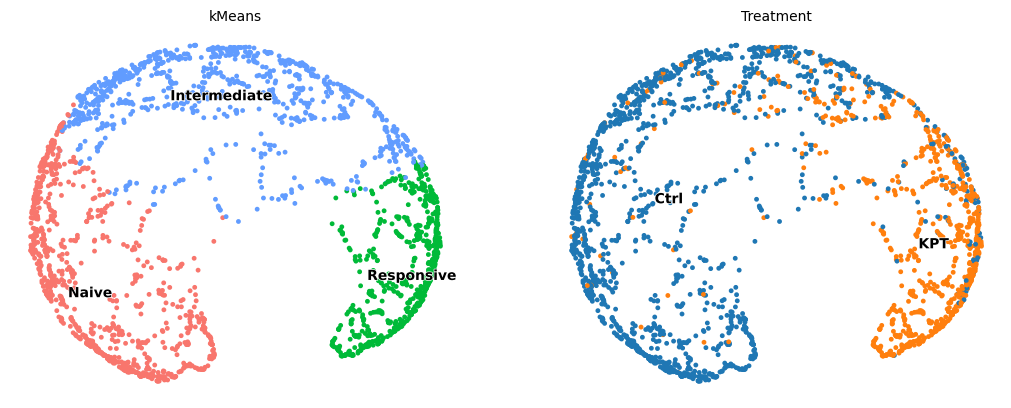

In [130]:
organa.obsm['X_tsne'] = x_phate
scv.pl.scatter(organa, basis = 'tsne', color = ['kMeans', 'Treatment'], frameon = False, legend_loc='on data')

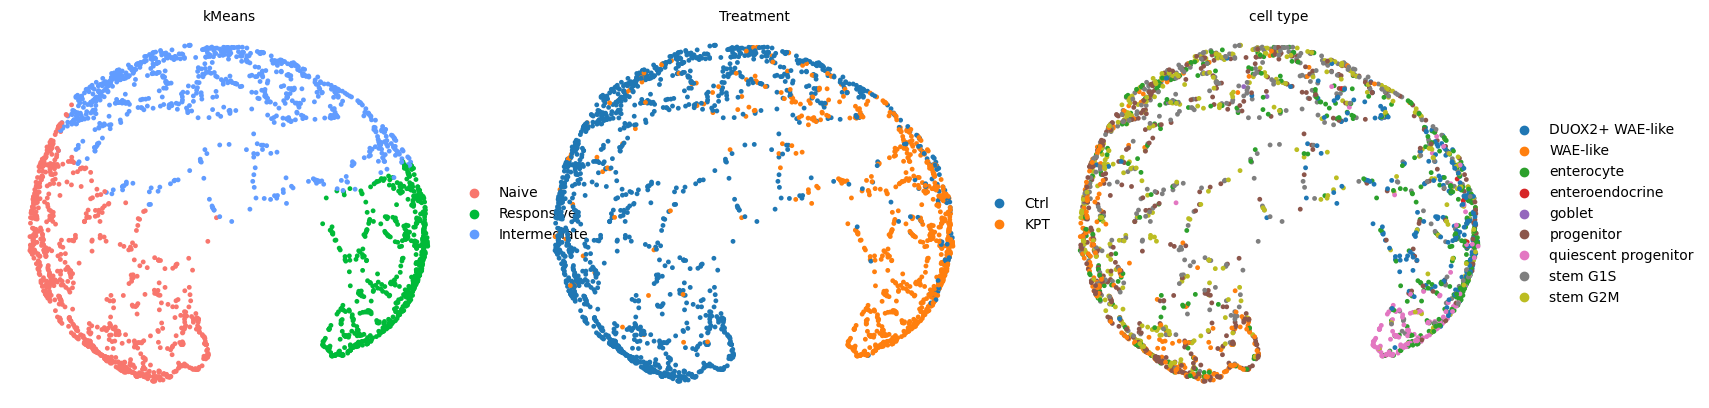

In [141]:
scv.pl.scatter(organa, basis = 'tsne', color = ['kMeans', 'Treatment', 'cell_type'], frameon = False, legend_loc='right margin')

In [ ]:
organa.obs['Clusters'] = list(organa.obs['kMeans'])
organa.obs['Clusters'] = organa.obs['Clusters'].astype('category')

Create barchart of cells from each cluster colored according to cell type

In [ ]:
GCN = pd.DataFrame(y_pred_all, columns=['Ctrl', 'KPT'])
GCN['Treatment'] = list(organa.obs['Treatment'])
GCN['Clusters'] = list(organa.obs['Clusters'])
GCN['Prediction'] = GCN[['Ctrl', 'KPT']].idxmax(axis=1)

<AxesSubplot:xlabel='Clusters'>

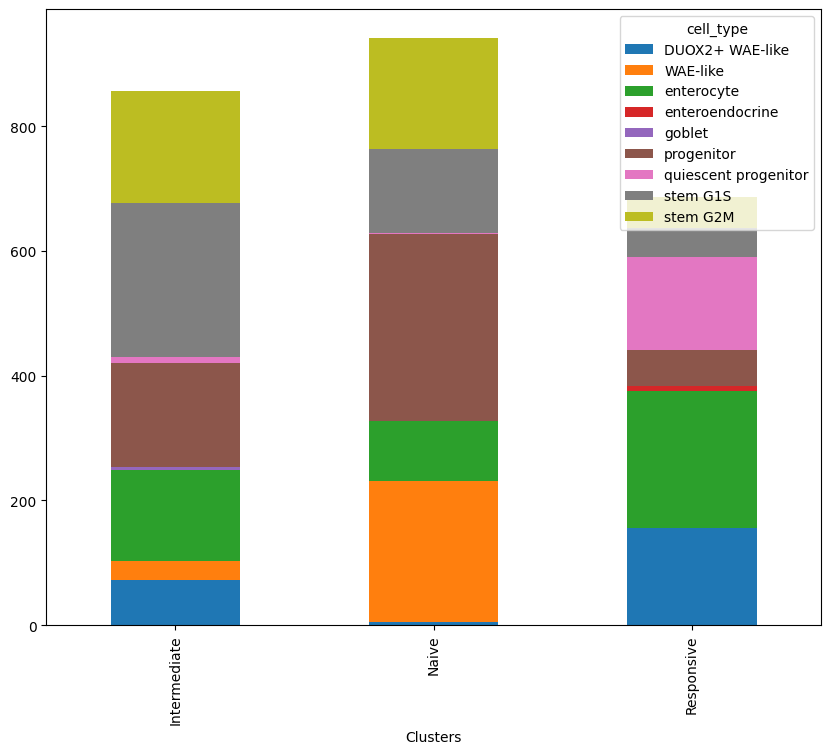

In [144]:
pd.crosstab(organa.obs.Clusters, organa.obs.cell_type).plot(kind='bar', 
                                                color = organa.uns['cell_type_colors'], 
                                                stacked=True, figsize=(10,8))

<AxesSubplot:xlabel='kMeans_orig'>

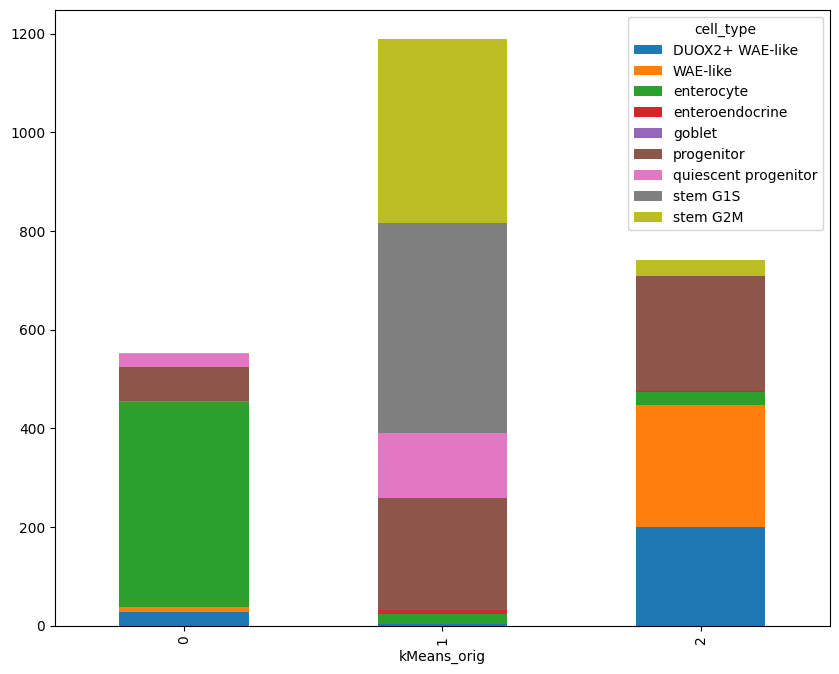

In [147]:
pd.crosstab(organa.obs.kMeans_orig, organa.obs.cell_type).plot(kind='bar', 
                                                color = organa.uns['cell_type_colors'], 
                                                stacked=True, figsize=(10,8))

Visualize barchart of cells from each cluster colored by predicted treatment condition based on the GCN softmax probabilities

<AxesSubplot:xlabel='Clusters'>

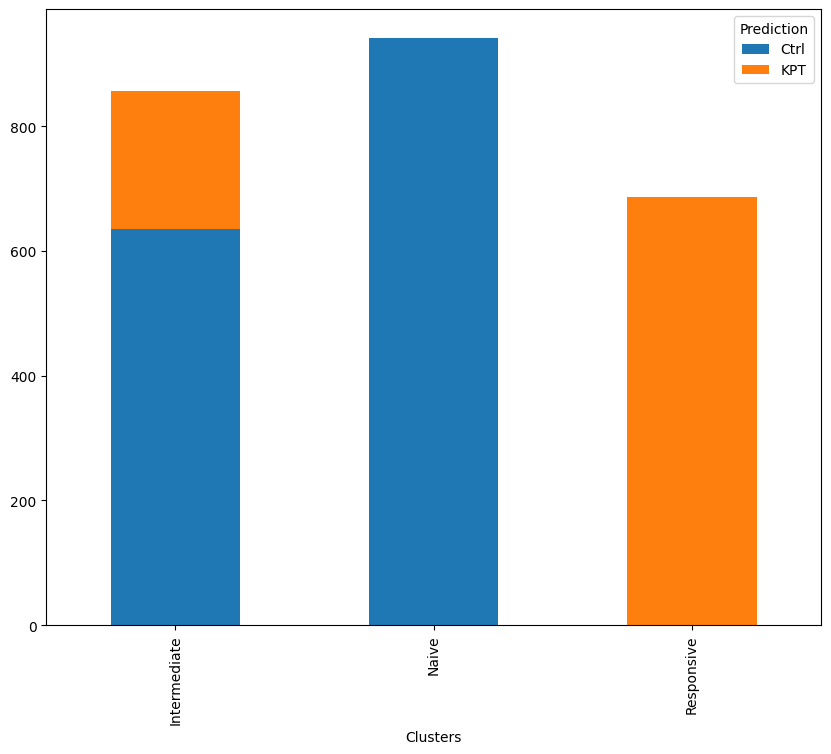

In [153]:
pd.crosstab(GCN.Clusters, GCN.Prediction).plot(kind='bar', 
                                                color = organa.uns['Treatment_colors'], 
                                                stacked=True, figsize=(10,8))

<AxesSubplot:xlabel='Clusters_orig'>

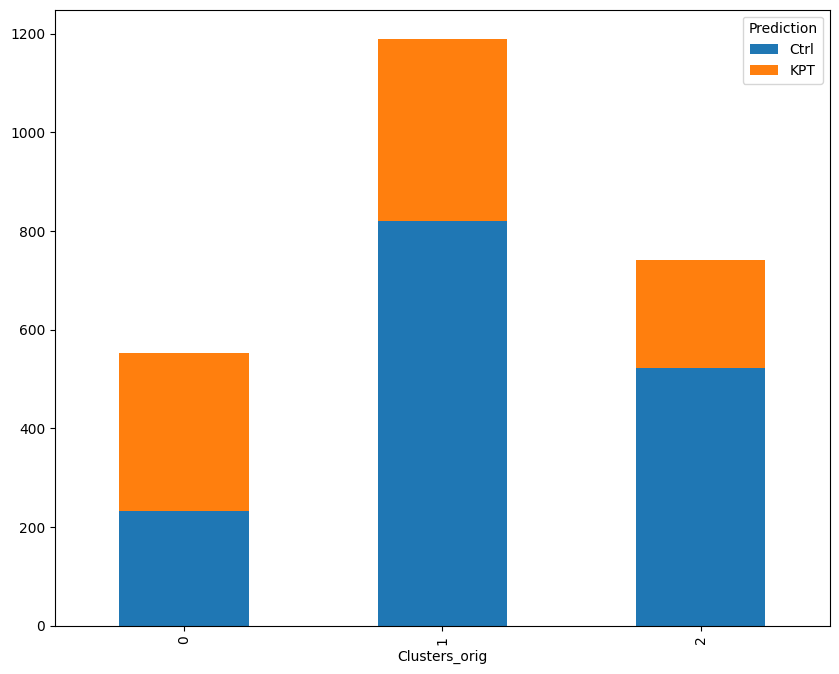

In [158]:
pd.crosstab(GCN.Clusters_orig, GCN.Prediction).plot(kind='bar', 
                                                color = organa.uns['Treatment_colors'], 
                                                stacked=True, figsize=(10,8))

<AxesSubplot:xlabel='Clusters'>

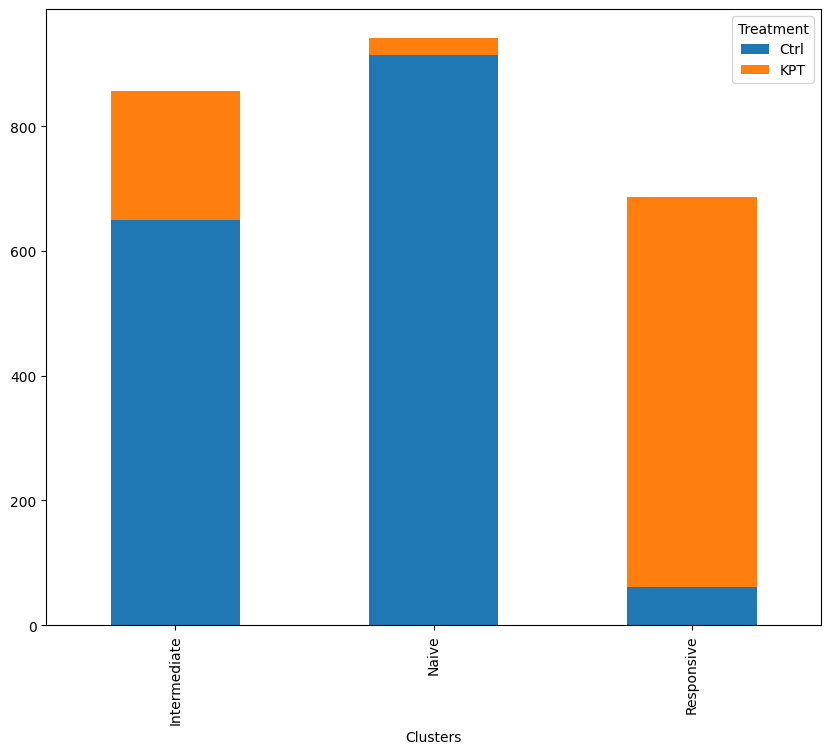

In [154]:
pd.crosstab(GCN.Clusters, GCN.Treatment).plot(kind='bar', 
                                                color = organa.uns['Treatment_colors'], 
                                                stacked=True, figsize=(10,8))

In [155]:
GCN['Clusters_orig'] = list(organa.obs['kMeans_orig'])
GCN

,Ctrl,KPT,Method,Treatment,Prediction,Clusters,Clusters_orig
0,0.861448,0.138552,GCN,Ctrl,Ctrl,Naive,0
1,0.821678,0.178322,GCN,Ctrl,Ctrl,Naive,1
2,0.861835,0.138165,GCN,Ctrl,Ctrl,Naive,1
3,0.805896,0.194104,GCN,Ctrl,Ctrl,Naive,0
4,0.088442,0.911558,GCN,KPT,KPT,Responsive,0
...,...,...,...,...,...,...,...
2479,0.237696,0.762304,GCN,Ctrl,KPT,Responsive,2
2480,0.704624,0.295376,GCN,Ctrl,Ctrl,Intermediate,1
2481,0.901365,0.098635,GCN,Ctrl,Ctrl,Naive,2
2482,0.884578,0.115422,GCN,Ctrl,Ctrl,Intermediate,2


In [123]:
organa.uns['kMeans_colors'] = color_list

In [138]:
organa.uns['Clusters_colors'] = color_list

In [134]:
organa.obs['Clusters'] = list(organa.obs['kMeans'])
organa.obs['Clusters'] = organa.obs['Clusters'].astype('category')
organa.obs['Clusters']

GTCATCTAGATA           Naive
TTCAGAGACCCC           Naive
GTCCTTGAAGCG           Naive
ATTCGGATAGCG           Naive
CAGACTATAAAT      Responsive
                    ...     
GAGGTCGTGCTA      Responsive
GTAAGAATAGTC    Intermediate
TGCCTGTGGAAT           Naive
ACAGAGTATCGT    Intermediate
TTTGAGAGTCCT      Responsive
Name: Clusters, Length: 2484, dtype: category
Categories (3, object): ['Intermediate', 'Naive', 'Responsive']

In [136]:
sc.tl.rank_genes_groups(organa, groupby='Clusters', method='wilcoxon')

{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='Clusters'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

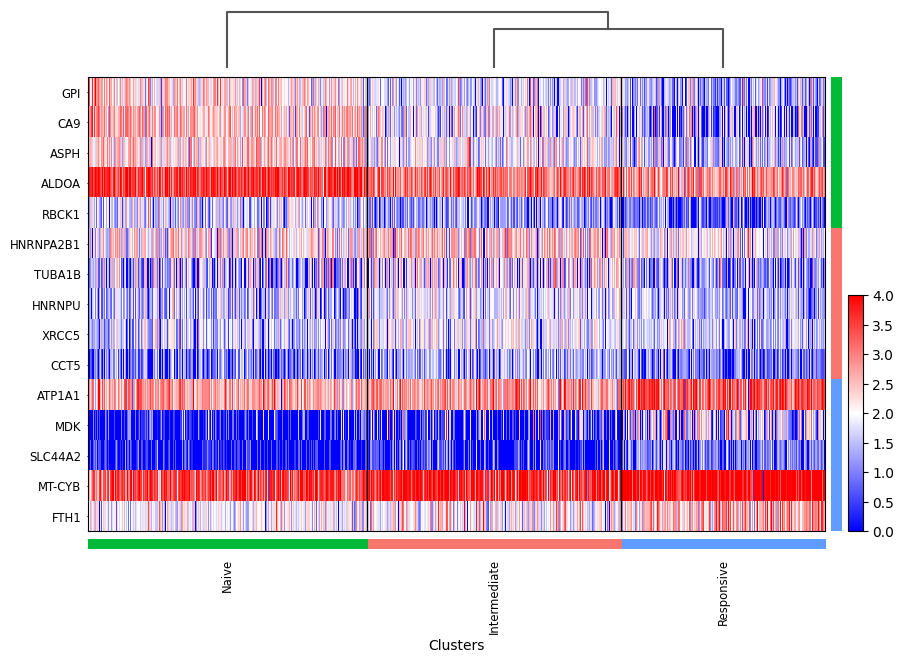

In [139]:
sc.pl.rank_genes_groups_heatmap(organa, n_genes=5, swap_axes=True, 
                                vmin=0, vmax=4, cmap='bwr', 
                                figsize=(10,7), show=False)